# White Noise

when que receive a signal of only white noise the variance in theory will be infinite, but the observation through a device generate an impulse response that discreteize the signal and produce a finite variance. We are going to check this here in order to find a way to compute $n_0$ from:

$$\sigma^2 = \int \frac{N_0}{2} |H(f)| df$$

In [20]:
# generate a random noise, we are going to thin in regular grid using fft so the time sampling is not relevant.
from scipy.signal import welch
from matplotlib import mlab

import numpy as np
import scipy as sp
import scipy.signal as signal
import scipy.fftpack as fftpack
from scipy.interpolate import interp1d
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import sys
sys.path.append("../../")
from mfilter.regressions import * #here it is the regression
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples


In [ ]:
# functions and constants

### Whitening data
A random process $x(t)$ is considered white if it's zero mean and uncorrelated

$$ \mu = \mathcal{E}[x(t)] = 0$$
$$ C_x(t_j, t_i) = C_0\delta(t_i - t_j)$$

As a consecuence, the power spectral density of a white process is a constant at every frequency.

A non-white (colored) noise process is instead characterized by a given distribution of the power per unit of frequency along the available frequency bandwidth.
Whitening operation on a given non-white process corresponds to force such a process to satisfy the conditions described above for a white process. 

The process is clear and simple:
* first calculate the fourier transform of a signal $x(t)$ to $X(f)$
* then estimate his Amplitude Spectral Density (ASD)
* Divide $X(f)$ by the ASD
* Perfom transform to time domain if it is necessary

Here we are goign to check some simple answers and clarify doubts about this procedure, like:

* Does the Whitening operation change the value/scale of the input signal?
* Does the Whitening operation affect the detection of a signal?
* Can we loss information by doing this procedure?

-0.5 0.49875 0.0 0.5


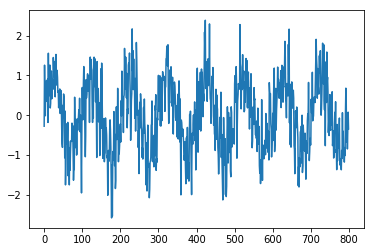

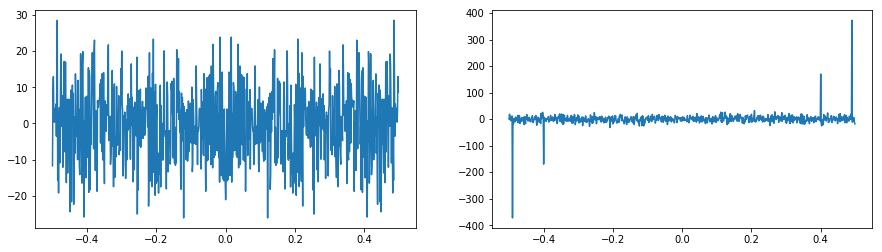

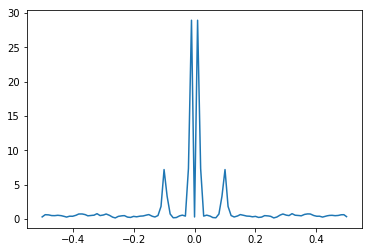

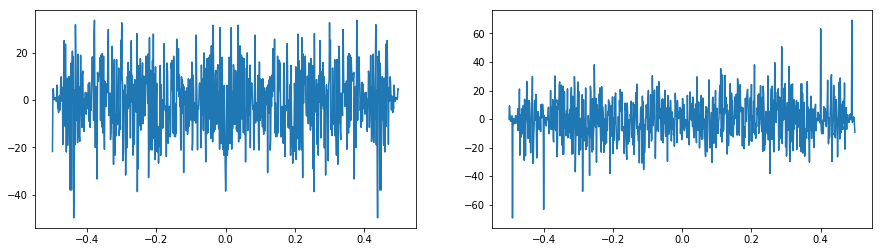

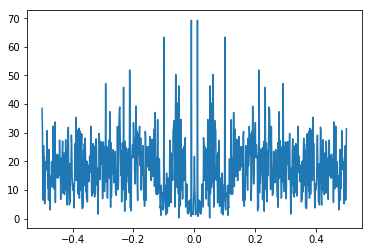

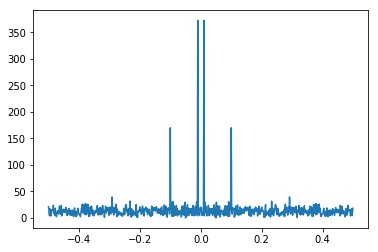

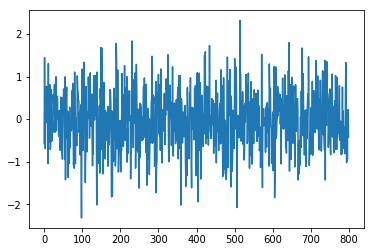

In [47]:
# simulate a white noise with a sinusoidal signal
N=800
times = TimesSamples(n=N, delta=1, struct="regular")
data = np.random.normal(0, 0.5, len(times)) + np.sin(2 * np.pi * 0.01 * times) + 0.4*np.sin(2 * np.pi * 0.1 * times)

plt.plot(times, data)

freqs = np.fft.fftfreq(len(times))
tilde = np.fft.fft(data)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(np.roll(freqs, len(times)//2), np.roll(np.real(tilde), len(times//2)))
ax2.plot(np.roll(freqs, len(times)//2), np.roll(np.imag(tilde), len(times//2)))

pxx, freqs2 = mlab.psd(data, Fs = 1, NFFT = len(times)//8)
print(min(freqs), max(freqs), min(freqs2), max(freqs2))
psd = interp1d(freqs2, pxx)
plt.figure()
plt.plot(np.roll(freqs, len(times)//2), np.roll(psd(np.abs(freqs)), len(times)//2))
tilde2 = tilde / np.sqrt(psd(np.abs(freqs)))
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(np.roll(freqs, len(times)//2), np.roll(np.real(tilde2), len(times//2)))
ax2.plot(np.roll(freqs, len(times)//2), np.roll(np.imag(tilde2), len(times//2)))

fig = plt.figure()
plt.plot(np.roll(freqs, len(times)//2), np.roll(np.abs(tilde2), len(times)//2))
fig = plt.figure()
plt.plot(np.roll(freqs, len(times)//2), np.roll(np.abs(tilde), len(times)//2))
data2 = np.fft.ifft(tilde2)
fig = plt.figure()
plt.plot(times, np.real(data2))

/home/astro/.local/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'corr from FFT of welch and auto-corr.')

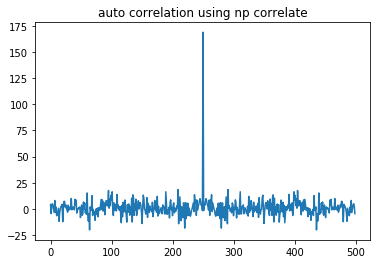

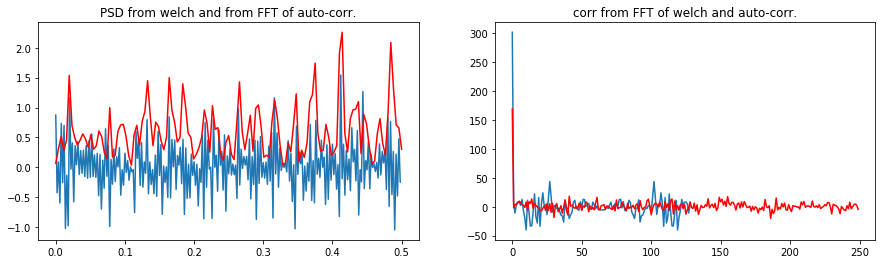

In [4]:
N = 500
true_sigma = 0.56
data = np.random.normal(0, true_sigma, N)

time = TimesSamples(n=N, delta=1, struct="regular")
dd = TimeSeries(data, times=time)
freq = FrequencySamples(input_time=time, 
                        minimum_frequency=np.fft.fftfreq(N, d=1)[1], 
                        maximum_frequency=np.fft.fftfreq(N, d=1)[N//2-1], 
                        samples_per_peak=1)
lw_psd = freq.lomb_scargle(time, dd, norm="psd")

# calculating the auto-correlation function on regular time
corr = np.correlate(data, data, mode="same")
plt.plot(corr)
plt.title("auto correlation using np correlate")
psd = sp.fftpack.fft(corr)
f, corr_s = welch(data, fs=1, return_onesided=True) 
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(sp.fftpack.fftfreq(N, d=1)[:N//2], psd[:N//2]/N)
ax1.plot(f, corr_s, 'r')
ax1.set_title("PSD from welch and from FFT of auto-corr.")

ax2.plot(sp.fftpack.ifft(corr_s) * N)
ax2.plot(corr[N//2:], 'r')
ax2.set_title("corr from FFT of welch and auto-corr.")

0.33570479784801455


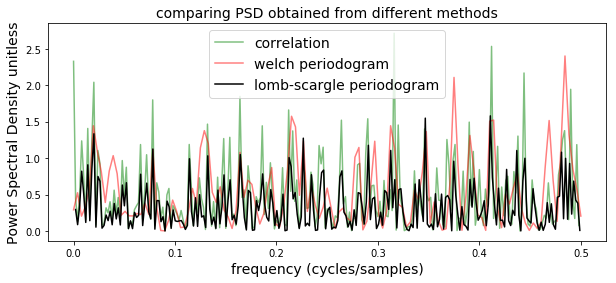

In [5]:
def autocovariance(Xi, N, k, Xs):
    autoCov = 0
    for i in np.arange(0, N-k):
        autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
    return (1/(N-1))*autoCov

fft_d = np.fft.fft(data)
norm = autocovariance(data, N, 0, np.average(data))
print(norm)
# norm = 1
psd_c = (np.abs(fft_d)**2) / norm
pxx, f = mlab.psd(data, Fs=1, sides="onesided")

plt.figure(figsize=(10, 4))
plt.plot(np.fft.fftfreq(N, d=1)[:N//2], psd_c[:N//2]/N/2, 'g', alpha=0.5, label="correlation")
plt.plot(f[:], pxx[:], 'r', alpha=0.5, label="welch periodogram")
plt.plot(freq, lw_psd, 'k', label="lomb-scargle periodogram")
plt.title("comparing PSD obtained from different methods", fontsize=14)
plt.legend(fontsize=14)
plt.xlabel("frequency (cycles/samples)", fontsize=14)
plt.ylabel("Power Spectral Density unitless", fontsize=14)
plt.savefig("PSD-normalization.png", dpi=300)

In [6]:
help(FrequencySamples)

Help on class FrequencySamples in module mfilter.types.frequencyseries:

class FrequencySamples(mfilter.types.arrays.Array)
 |  Method resolution order:
 |      FrequencySamples
 |      mfilter.types.arrays.Array
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, initial_array=None, input_time=None, minimum_frequency=None, maximum_frequency=None, samples_per_peak=None, nyquist_factor=2, n_samples=None, df=None)
 |      class for creation of frequency samples on regular grid, on custom
 |      values, using an oversampling factor.
 |      
 |      :param input_time:          Array or array-like
 |                                  times of the original data
 |      :param minimum_frequency:   scalar (real)
 |                                  minimum frequency to compute, default 0
 |      :param maximum_frequency:   scalar (real)
 |                                  maximum frequency to compute
 |      :param samples_per_peak:    integer
 |                     

In [ ]:
np.fft.fftfreq(N, d=1)[N//2-1]